In [20]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import LSTMCell
from keras import Sequential, layers
from keras.layers import Embedding, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN, GRUCell, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Chargement du dataframe créé (preproccessing_text)
df = pd.read_csv('/mnt/c/Users/steph/OneDrive/Images/Rakuten/df_cleaned.csv') 

df.head()

,designation,description,productid,imageid,image_name,prdtypecode,Label,prdtypecode_base,text
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,0,Livres adultes,10,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,18,Journaux et Magazines,2280,journal arts art marche salon art asiatique pa...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,2,Accessoires de Jeux Vidéos,50,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,7,Jouets pour Enfants,1280,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,25,Livres,2705,guerre tuques luc grandeur veut organiser jeu ...


In [9]:
df['designation'] = df['designation'].astype('string')
df['description'] = df['description'].astype('string')

# remplacement des Nan par une chaîne de caractère
df['text'].fillna("''", inplace=True)

# Modélisation

In [10]:
#path = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data/'
path_output = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data/text/'

In [11]:
# Séparation de l'entraînement et du test
X = df['text']

# Variable cible à prédire
y = pd.DataFrame(df['prdtypecode']).astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Tokénisation

In [12]:
tokenizer = Tokenizer(num_words = 20000)

# tokénisation sur le texte d'entraînement
tokenizer.fit_on_texts(X_train)

# Conversion du texte en séquence numérique
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Comptage de nombre de mots uniques 
word_size = len(tokenizer.word_index) + 1  
# on ajoute +1 car on commence à l'index 0

print(len(X_train))
print(len(X_test))
print(word_size)

67932
16984
125174


In [13]:
# longueur max de chaque séquence de mots
maxlen = 400 

# représentation par un vecteur de 100 dimensions
embedding_dim = 100

# utilisation de séquences de même longueur
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("X_train", len(X_train))
print("X_test", len(X_test))

X_train 67932
X_test 16984


Création du modèle

In [14]:
model = Sequential()

model.add(layers.Embedding(word_size, embedding_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(27, activation='softmax'))

model.summary()


2023-11-07 10:02:56.304014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 10:02:56.441728: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          12517400  
                                                                 
 spatial_dropout1d (Spatial  (None, 400, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 399, 64)           12864     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 27)                1755      
                                                                 
Total params: 12532019 (47.81 MB)
Trainable params: 1253

In [15]:
lr =  0.001

model.compile(optimizer= Adam(learning_rate= lr), 
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

Mise en place de callbacks

In [16]:
# Sauvegarde des meilleurs poids du modèle au cours de l'entraînement 
checkpoint = ModelCheckpoint(filepath=path_output + 'conv1d_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max',
                             save_freq='epoch')

# Réduction automatique du learning rate
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=10,
                      restore_best_weights=True,
                      verbose=1,
                      mode='min')
        
# Arrêt de l'entraînement si le modèle n'évolue plus
lr_reduce = ReduceLROnPlateau(patience=2,
                              verbose=1)

callbacks = [checkpoint, early, lr_reduce]

Entraînement du model

In [17]:
history = model.fit(X_train, y_train.values,
                           batch_size = 200,
                           epochs = 20,
                           validation_data = [X_test, y_test.values],
                           callbacks = [checkpoint, early, lr_reduce])

Epoch 1/20
340/340 [==============================] - ETA: 0s - loss: 1.9599 - accuracy: 0.4818
Epoch 1: val_accuracy improved from -inf to 0.71514, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data/text/conv1d_model.h5


/home/workspace/API/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


340/340 [==============================] - 24s 68ms/step - loss: 1.9599 - accuracy: 0.4818 - val_loss: 1.0444 - val_accuracy: 0.7151 - lr: 0.0010
Epoch 2/20
340/340 [==============================] - ETA: 0s - loss: 0.7987 - accuracy: 0.7755
Epoch 2: val_accuracy improved from 0.71514 to 0.78056, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data/text/conv1d_model.h5
340/340 [==============================] - 23s 68ms/step - loss: 0.7987 - accuracy: 0.7755 - val_loss: 0.7590 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 3/20
340/340 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.8455
Epoch 3: val_accuracy improved from 0.78056 to 0.79828, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data/text/conv1d_model.h5
340/340 [==============================] - 22s 66ms/step - loss: 0.5375 - accuracy: 0.8455 - val_loss: 0.6918 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 4/20
340/340 [==============================] - ETA: 0s - loss: 0.3890 -

Evaluation

In [18]:
# Calcul des prédictions
y_pred = model.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)

# Obtenir le score d'exactitude
valid_score = model.evaluate(X_test, y_test.values, batch_size=200)
accuracy = valid_score[1] * 100
loss = valid_score[0]
conv1D = np.round(accuracy, 2)

85/85 [==============================] - 1s 9ms/step - loss: 0.6824 - accuracy: 0.8041


In [21]:
# Calcul du F1-score pondéré sur l'ensemble de test
f1_score_macro = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
f1_weighted = f1_score(y_test, y_pred.argmax(axis=1), average='weighted')
print(f1_weighted)

0.8055229942057126


In [22]:
# Affichage du rapport de classification
classification_rep = classification_report(y_test, y_pred_class)
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.57      0.47       612
           1       0.71      0.62      0.66       521
           2       0.80      0.80      0.80       357
           3       0.95      0.83      0.88       161
           4       0.73      0.78      0.75       539
           5       0.84      0.87      0.86       786
           6       0.77      0.51      0.61       146
           7       0.68      0.75      0.71       961
           8       0.67      0.54      0.60       424
           9       0.95      0.93      0.94       974
          10       0.95      0.88      0.91       169
          11       0.89      0.78      0.83       507
          12       0.79      0.77      0.78       672
          13       0.86      0.85      0.85      1013
          14       0.90      0.93      0.91       841
          15       0.86      0.85      0.86       137
          16       0.84      0.80      0.82      1029
   

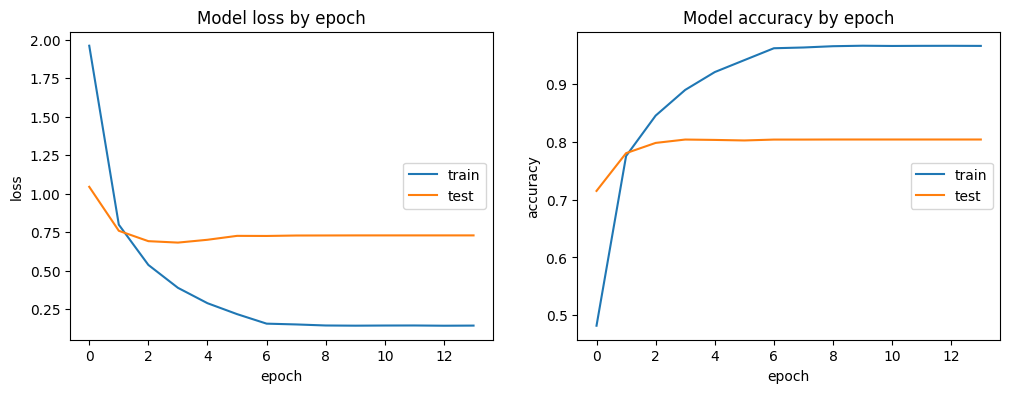

In [23]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Prédicitons

In [25]:
# Prédictions du modèle
y_pred = model.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)


531/531 [==============================] - 2s 4ms/step


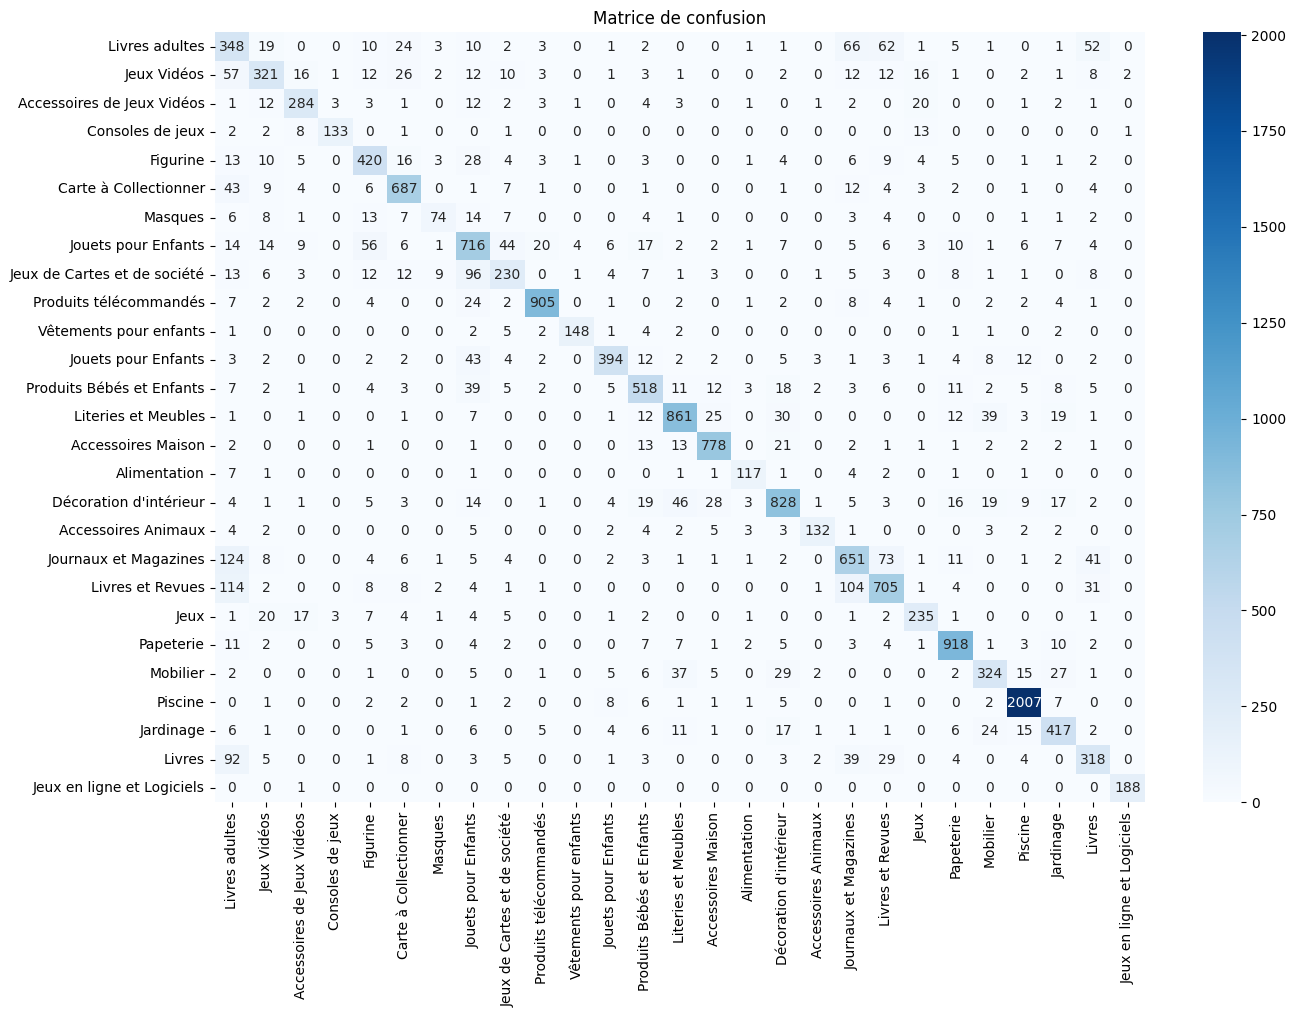

In [26]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_class)

# liste des labels
labels = ["Livres adultes", "Jeux Vidéos", "Accessoires de Jeux Vidéos", "Consoles de jeux", "Figurine", "Carte à Collectionner",
          "Masques", "Jouets pour Enfants", "Jeux de Cartes et de société", "Produits télécommandés",
          "Vêtements pour enfants", "Jouets pour Enfants", "Produits Bébés et Enfants",
          "Literies et Meubles", "Accessoires Maison", "Alimentation", "Décoration d'intérieur", "Accessoires Animaux",
          "Journaux et Magazines", "Livres et Revues", "Jeux", "Papeterie",
          "Mobilier", "Piscine", "Jardinage", "Livres", "Jeux en ligne et Logiciels"]

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion')
plt.show()

In [27]:
# Parcourir chaque élément de la matrice de confusion
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Vérification si le nombre d'erreurs est supérieur à 20 et si les classes sont différentes
        if cm[i, j] > 20 and i != j:
            print(f"La classe {i} est souvent prise pour la classe {j}, nombre d'erreurs = {cm[i, j]}")

La classe 0 est souvent prise pour la classe 5, nombre d'erreurs = 24
La classe 0 est souvent prise pour la classe 18, nombre d'erreurs = 66
La classe 0 est souvent prise pour la classe 19, nombre d'erreurs = 62
La classe 0 est souvent prise pour la classe 25, nombre d'erreurs = 52
La classe 1 est souvent prise pour la classe 0, nombre d'erreurs = 57
La classe 1 est souvent prise pour la classe 5, nombre d'erreurs = 26
La classe 4 est souvent prise pour la classe 7, nombre d'erreurs = 28
La classe 5 est souvent prise pour la classe 0, nombre d'erreurs = 43
La classe 7 est souvent prise pour la classe 4, nombre d'erreurs = 56
La classe 7 est souvent prise pour la classe 8, nombre d'erreurs = 44
La classe 8 est souvent prise pour la classe 7, nombre d'erreurs = 96
La classe 9 est souvent prise pour la classe 7, nombre d'erreurs = 24
La classe 11 est souvent prise pour la classe 7, nombre d'erreurs = 43
La classe 12 est souvent prise pour la classe 7, nombre d'erreurs = 39
La classe 13 es